In [1]:
import torch
from torch.testing import assert_close
from torch import allclose, nn, tensor
torch.set_printoptions(linewidth=200, precision=3)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'mps'
device_dtype = torch.float16 if device == 'cuda' else torch.float32

## Load the model

In [3]:
from diffusers import StableDiffusionXLControlNetXSPipeline, ControlNetXSModel, AutoencoderKL
from diffusers.utils import load_image
import numpy as np
import torch

import cv2
from PIL import Image

Info: `UmerDebugLogger` created. This is a logging class that will be deleted when the PR to integrate ControlNet-XS is done.


In [4]:
import random
def seed_everything(seed):
    # paper used deprecated `seed_everything` from pytorch lightning
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [25]:
# download an image
image = load_image('input_images/ugly_person_square.png')

# initialize the models and pipeline
controlnet = ControlNetXSModel.from_pretrained(
    "UmerHA/ConrolNetXS-SDXL-canny", torch_dtype=torch.float16
)
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = StableDiffusionXLControlNetXSPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", controlnet=controlnet, vae=vae, torch_dtype=torch.float16
)
pipe.enable_model_cpu_offload()

# get canny image
image = np.array(image)
image = cv2.Canny(image, 50, 200)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

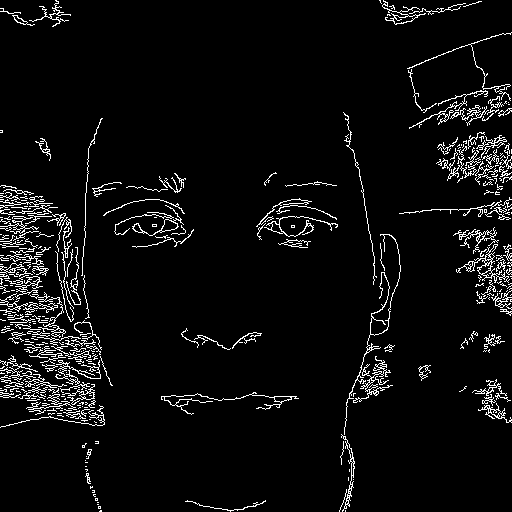

In [26]:
canny_image

In [27]:
prompt = "a cineastic photo of a movie super villian, dark style, rainy background, perfect lighting"

negative_prompt="low quality, ugly, comic"

In [28]:
def get_cnxs_image(ctrl_scale):
    seed_everything(123456)
    return pipe(
        prompt, negative_prompt=negative_prompt,
        image=canny_image,
        controlnet_conditioning_scale=ctrl_scale
    ).images[0]

In [29]:
ims = []
for cs in torch.arange(0.3,1.01,0.3):
    im = get_cnxs_image(ctrl_scale=cs.item())
    ims.append((cs,im))

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [30]:
import matplotlib.pyplot as plt

def shape(o): return o.shape if hasattr(o,'shape') else o.size

def make_channel_last(im): return einops.rearrange(im, 'c w h-> w h c') if shape(im)[0] in (1,3) else im

def compare_images(images, titles=None, figsize=(2, 2)):
    n = len(images)
    if titles is None: titles = [None] * n
    elif len(titles) != n: raise ValueError("Number of titles must match number of images")

    plt.figure(figsize=(figsize[0] * n, figsize[1]))

    for i, image in enumerate(images):
        plt.subplot(1, n, i + 1)
        plt.imshow(make_channel_last(image))
        if titles[i] is not None: plt.title(titles[i])

        plt.xticks([])
        plt.yticks([])
    
    plt.show()
    

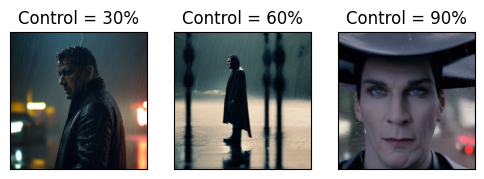

In [31]:
compare_images(
    [im for cs,im in ims],
    [str(f'Control = {cs*100:.0f}%') for cs,im in ims],
)

In [15]:
prompt = "an award-winning photo of a scenic mediterrian temple, in front of the ocean, warm lighting"
negative_prompt = "low quality, bad quality, sketches, cartoon"

In [16]:
def get_cnxs_image(ctrl_scale):
    seed_everything(123456)
    return pipe(
        prompt, negative_prompt=negative_prompt,
        image=canny_image,
        controlnet_conditioning_scale=ctrl_scale
    ).images[0]

In [17]:
detailled_ims = []
for cs in torch.arange(0.4,0.81,0.05):
    im = get_cnxs_image(ctrl_scale=cs.item())
    detailled_ims.append((cs,im))

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

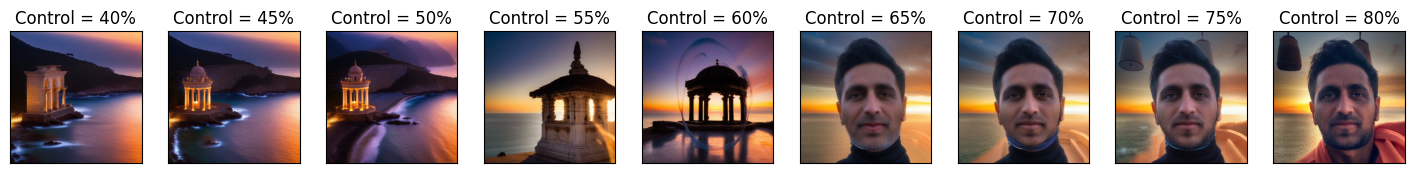

In [18]:
compare_images(
    [im for cs,im in detailled_ims],
    [str(f'Control = {cs*100:.0f}%') for cs,im in detailled_ims],
)